# Are Amazon product reviews generally more positive/negative for certain categories compared to others?

In [200]:
import pyspark.pandas as ps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Not in Requirements, poetry add vaderSentiment

# data = ps.read_parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
#data_sample = data.sample(frac=0.0001, random_state=42)
#print(data_sample.shape)
#data_sample.to_parquet('/data/data_sample.parquet', index_col=['reviewerID', 'asin'])

data = ps.read_parquet('/data/data_sample.parquet', index_col=['reviewerID', 'asin'])

ERROR:root:KeyboardInterrupt while sending command.68][Stage 13624:(0 + 0) / 468]
Traceback (most recent call last):
  File "/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martinwustinger/miniconda3/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
data_verified = data[data['verified'] == True]
data_not_verified = data[data['verified'] == False]

## Star Ratings

In [ ]:
def reduce_to_cat_stars(data):
    long_df = data.groupby(['category', 'overall']).size().reset_index(name='count')
    wide_df = long_df.pivot(index='category', columns='overall', values='count')
    wide_df.columns = [f'stars_{col}'[:-2] for col in wide_df.columns]
    wide_df = wide_df.fillna(0)

    df_cat_stars = wide_df.reset_index()
    df_cat_stars = df_cat_stars.sort_values(by=['category']).reset_index(drop=True)
    df_cat_stars = df_cat_stars.assign(number_of_ratings=lambda x: x['stars_1'] + x['stars_2'] + x['stars_3'] + x['stars_4'] + x['stars_5'])
    df_cat_stars = df_cat_stars.assign(average_rating=lambda x: (x['stars_1'] + x['stars_2']*2 + x['stars_3']*3 + x['stars_4']*4 + x['stars_5']*5) / x['number_of_ratings'])

    return df_cat_stars

data_cat_stars = reduce_to_cat_stars(data_verified)
ver_cat_stars = reduce_to_cat_stars(data_verified)
notver_cat_stars = reduce_to_cat_stars(data_not_verified)


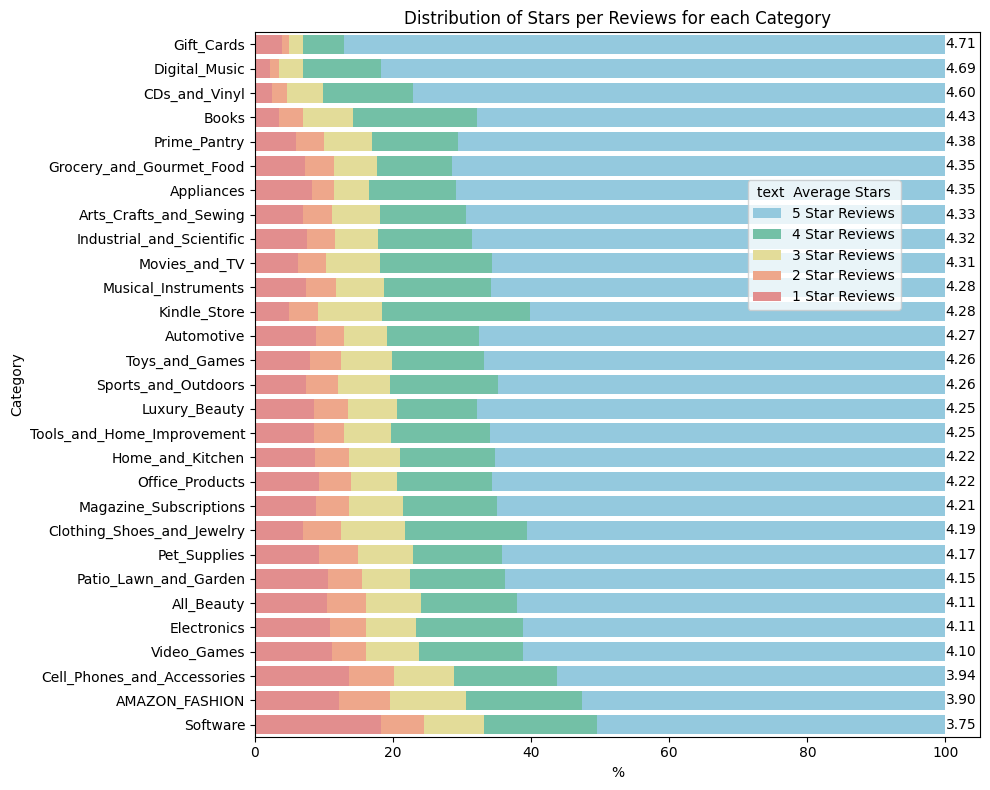

In [ ]:
def plot_cat_stars(df_cat_stars):
    # Calculate comulative values
    com_df_cat_stars = df_cat_stars.copy()
    for i in range(1, 5):
        com_df_cat_stars[f'stars_{i+1}'] += com_df_cat_stars[f'stars_{i}']
    # Normalize and convert to Percent
    for i in range(1, 6):
        com_df_cat_stars[f'stars_{i}'] *= 100 / com_df_cat_stars[f'stars_5']


    pd_com_df_cat_stars = com_df_cat_stars.to_pandas()
    pd_com_df_cat_stars = pd_com_df_cat_stars.sort_values(by=['average_rating'], ascending=False).reset_index(drop=True)

    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.barplot(x='stars_5', y='category', data=pd_com_df_cat_stars, orient='h', color=pastel_palette[0], label='5 Star Reviews')
    sns.barplot(x='stars_4', y='category', data=pd_com_df_cat_stars, orient='h', color=pastel_palette[1], label='4 Star Reviews')
    sns.barplot(x='stars_3', y='category', data=pd_com_df_cat_stars, orient='h', color=pastel_palette[2], label='3 Star Reviews')
    sns.barplot(x='stars_2', y='category', data=pd_com_df_cat_stars, orient='h', color=pastel_palette[3], label='2 Star Reviews')
    sns.barplot(x='stars_1', y='category', data=pd_com_df_cat_stars, orient='h', color=pastel_palette[4], label='1 Star Reviews')

    # Annotate each bar with the corresponding average rating value
    for i, row in pd_com_df_cat_stars.iterrows():
        ax1.text(row['stars_5'], i, f'{row["average_rating"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title('Distribution of Stars per Reviews for each Category')

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.9, 0.8), title='text  Average Stars')

    # Show the plot
    plt.show()

plot_cat_stars(data_cat_stars)
# plot_cat_stars(ver_cat_stars)
# plot_cat_stars(notver_cat_stars)

## Subsample Dataset for Sentiment Analysis

In [ ]:
max_number_of_samples_per_category = 1000

def subsample_for_sentiment(df):
    subsampled_df = ps.DataFrame(df).drop(df.index)
    for category in df['category'].drop_duplicates().reset_index(drop=True).to_pandas():
        print(f"Currently subsampling category {category} ...")
        rows_for_category = df[df['category'] == category]
        frac = max_number_of_samples_per_category / len(rows_for_category)
        if frac >= 1:
            subsampled_df = subsampled_df.union(rows_for_category)
        else:
            for stars in range(1, 6):
                rows_for_category_and_rating = rows_for_category[rows_for_category['overall'] == stars]
                if not rows_for_category_and_rating.empty:
                    sampled_rows = rows_for_category_and_rating.sample(frac = frac, replace=False, random_state=42)
                    subsampled_df = subsampled_df.union(sampled_rows)

    difference_average_rating = reduce_to_cat_stars(df)['average_rating'].to_numpy() - reduce_to_cat_stars(subsampled_df)['average_rating'].to_numpy()
    threshold = 0.01
    print(f"{sum(difference_average_rating > threshold)} categories exceed threshold of {threshold}:")
    print(difference_average_rating[difference_average_rating > threshold])

    return subsampled_df


subsampled_data = subsample_for_sentiment(data)
print(subsampled_data.shape)
#subsampled_data_sentiment.to_parquet('/data/subsampled_data_sentiment.parquet', index_col=['reviewerID', 'asin'])

ERROR:root:KeyboardInterrupt while sending command.68][Stage 13624:(0 + 0) / 468]
Traceback (most recent call last):
  File "/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martinwustinger/miniconda3/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

## Sentiment Analysis with VaderSentiment

In [ ]:
from pyspark.sql.functions import col, coalesce, lit
from pyspark.sql.types import StringType, DoubleType

def reduce_to_sentiment(df):
    print(len(df))
    print(f"Number of rows with empty reviewText: {len(df[df['reviewText'].isna()])}")
    print(f"Number of rows with empty summary: {len(df[df['summary'].isna()])}")
    df['text'] = df['summary'] + ' - ' + df['reviewText']
    df = df[['category', 'overall', 'verified', 'text']].dropna()  # Remove not needed rows and cols

    df = df.to_spark()

    calculate_neg_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['neg'], DoubleType())
    df = df.withColumn("vader_neg", calculate_neg_score(df['text']))
    calculate_neu_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['neu'], DoubleType())
    df = df.withColumn("vader_neu", calculate_neu_score(df['text']))
    calculate_pos_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['pos'], DoubleType())
    df = df.withColumn("vader_pos", calculate_pos_score(df['text']))
    calculate_compound_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'], DoubleType())
    df = df.withColumn("vader_compound", calculate_compound_score(df['text']))

    df = df[['category', 'overall', 'verified', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']]
    calculate_sentiment = udf(lambda compound: 'very_positive' if compound >= 0.75 
                                else ('positive' if compound >= 0.25 
                                else ('very_negative' if compound <= -0.75 
                                else ('negative' if compound <= -0.25
                                else 'neutral'))), StringType())
    df = df.withColumn("sentiment", calculate_sentiment(df['vader_compound']))
    return df

def reduce_to_cat_sentiment(df):
    long_df = df.groupBy("category", "sentiment").agg(count("*").alias("count")).toPandas()
    wide_df = long_df.pivot(index='category', columns='sentiment', values='count')
    # wide_df.columns = [f'sentiment_{col}' for col in wide_df.columns]
    wide_df = wide_df.fillna(0)

    df_cat_sentiment = wide_df.reset_index()
    df_cat_sentiment = df_cat_sentiment.sort_values(by=['category']).reset_index(drop=True)
    df_cat_sentiment = df_cat_sentiment.assign(number_of_ratings=lambda x: x['very_positive'] + x['positive'] + x['neutral'] + x['negative'] + x['very_negative'])
    df_cat_sentiment = df_cat_sentiment.assign(average_sentiment=lambda x: (x['very_positive'] + x['positive'] * 0.5 - x['negative'] * 0.5 - x['very_negative']) / x['number_of_ratings'])

    return df_cat_sentiment



data_sentiment = reduce_to_sentiment(subsampled_data)
data_cat_sentiment = reduce_to_cat_sentiment(data_sentiment)
data_cat_sentiment.head(5)

230139802


Number of rows with empty reviewText: 150958


Number of rows with empty summary: 71659


ERROR:root:KeyboardInterrupt while sending command.               (0 + 4) / 468]
Traceback (most recent call last):
  File "/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martinwustinger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-BAx41V68-py3.11/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martinwustinger/miniconda3/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

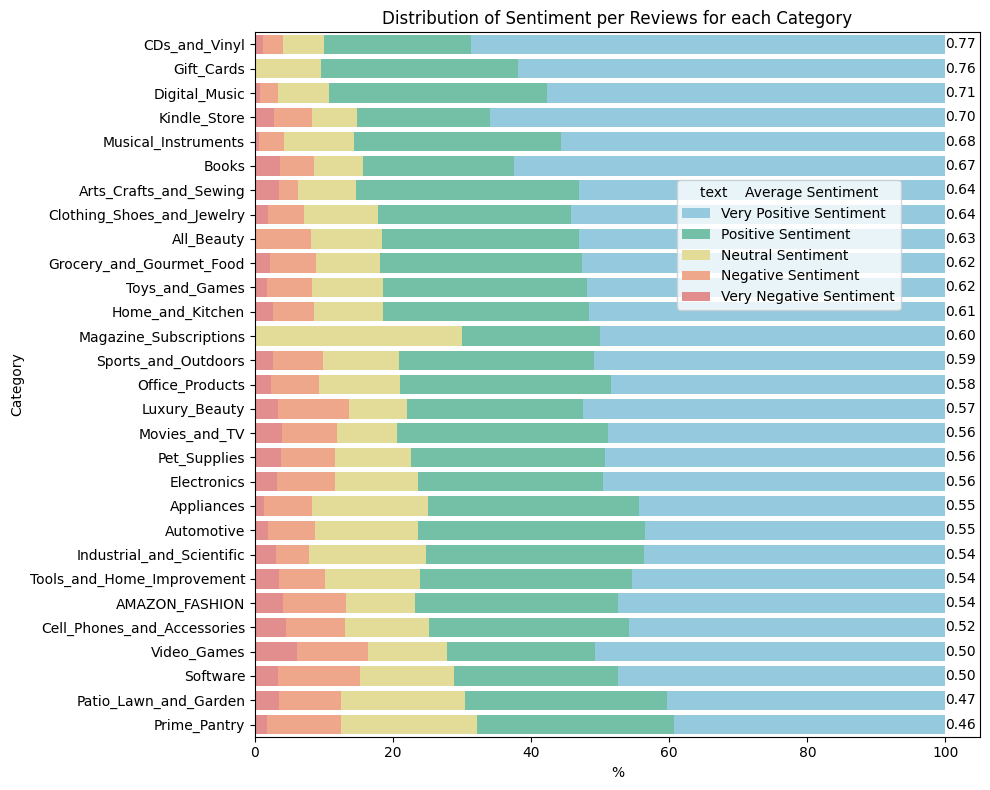

In [ ]:
def plot_cat_sentiment(df_cat_sentiment):
    # Calculate comulative values
    com_df_cat_sentiment = df_cat_sentiment.copy()
    sentiments = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    for i in range(0, 4):
        com_df_cat_sentiment[sentiments[i+1]] += com_df_cat_sentiment[sentiments[i]]
    # Normalize and convert to Percent
    for i in range(0, 5):
        com_df_cat_sentiment[sentiments[i]] *= 100 / com_df_cat_sentiment[sentiments[4]]


    com_df_cat_sentiment = com_df_cat_sentiment.sort_values(by=['average_sentiment'], ascending=False).reset_index(drop=True)

    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.barplot(x='very_positive', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[0], label='Very Positive Sentiment')
    sns.barplot(x='positive', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[1], label='Positive Sentiment')
    sns.barplot(x='neutral', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[2], label='Neutral Sentiment')
    sns.barplot(x='negative', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[3], label='Negative Sentiment')
    sns.barplot(x='very_negative', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[4], label='Very Negative Sentiment')

    # Annotate each bar with the corresponding average rating value
    for i, row in com_df_cat_sentiment.iterrows():
        ax1.text(row['very_positive'], i, f'{row["average_sentiment"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title('Distribution of Sentiment per Reviews for each Category')

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.9, 0.8), title='text    Average Sentiment')

    # Show the plot
    plt.show()

plot_cat_sentiment(data_cat_sentiment)
# plot_cat_sentiment(ver_cat_sentiment)
# plot_cat_sentiment(notver_cat_sentiment)